In [1]:
import sklearn
import pymc as pm
import arviz as az

In [36]:
import sklearn.datasets
import pandas as pd


irisX, cat = sklearn.datasets.load_iris(return_X_y = True,as_frame=True)

In [37]:
sklearn.datasets.load_iris().target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [38]:
# center the data
irisX = irisX - irisX.mean()

In [5]:
pm.__version__

'5.22.0'

In [6]:
cat.unique()

array([0, 1, 2])

In [7]:
nclass = len(cat.unique())
nparam = 4


with pm.Model() as iris_model:
    X_data = pm.Data('X_data', irisX)
    y_obs_data = pm.Data('y_obs_data', cat)
    alfa = pm.Normal('alfa', mu=0, sigma=5, shape=nclass)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=(nparam, nclass))
    mu = pm.math.dot(X_data, beta) + alfa
     
    yl = pm.Categorical('obs', logit_p=mu, observed=y_obs_data)
 

with iris_model:
    idata = pm.sample(idata_kwargs={"log_likelihood": True})

 


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [8]:
az.summary(idata, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alfa[0],-1.64,3.78,-9.51,5.38,0.06,0.06,3592.78,2510.58,1.00
alfa[1],6.55,3.21,0.65,13.30,0.06,0.05,3285.74,2811.94,1.00
alfa[2],-4.71,3.43,-11.64,1.84,0.06,0.06,3395.21,2671.31,1.00
"beta[0, 0]",-0.29,4.22,-8.09,8.52,0.07,0.07,3745.66,2903.14,1.00
"beta[0, 1]",1.25,3.24,-5.13,7.75,0.06,0.05,2837.27,2691.82,1.00
"beta[0, 2]",-1.00,3.25,-7.01,5.80,0.06,0.05,2981.84,2510.22,1.00
"beta[1, 0]",3.64,4.11,-5.12,11.22,0.06,0.06,4062.02,3065.14,1.00
"beta[1, 1]",-0.64,3.29,-7.26,5.75,0.06,0.05,3029.03,2815.54,1.00
"beta[1, 2]",-3.21,3.33,-9.73,3.25,0.06,0.05,3006.73,2976.94,1.00
"beta[2, 0]",-6.96,3.68,-13.94,0.45,0.07,0.06,2960.09,2659.96,1.00


Now try using pivot 

In [39]:

with pm.Model() as iris_model_pivot:
    X_data = pm.Data('X_data', irisX)
    y_obs_data = pm.Data('y_obs_data', cat)

    # Now parameters are only defined for categories 1 to (nclass-1)
    alfa = pm.Normal('alfa', mu=0, sigma=5, shape=nclass - 1)
    beta = pm.Normal('beta', mu=0, sigma=5, shape=(nparam, nclass - 1))

    # Compute logits only for the non-baseline categories
    mu_nonpivot = pm.math.dot(X_data, beta) + alfa

    # Add zeros explicitly for pivot class logits (category 0)
    zeros = pm.math.zeros((mu_nonpivot.shape[0], 1))
    mu = pm.math.concatenate([zeros, mu_nonpivot], axis=1)

    # Now use logit_p (stable!)
    yl = pm.Categorical('obs', logit_p=mu, observed=y_obs_data)

with iris_model_pivot:
    idata_pivot = pm.sample(idata_kwargs={"log_likelihood": True})


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alfa, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [40]:
az.summary(idata_pivot, hdi_prob=0.95, round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alfa[0],5.82,2.28,1.89,10.44,0.05,0.04,1864.31,2096.63,1.0
alfa[1],-4.35,2.86,-9.65,1.54,0.07,0.05,1916.01,2047.19,1.0
"beta[0, 0]",1.52,2.82,-3.79,7.13,0.06,0.05,2088.57,2174.78,1.0
"beta[0, 1]",-0.45,2.90,-5.99,5.20,0.07,0.05,1748.03,2266.94,1.0
"beta[1, 0]",-2.76,2.61,-7.93,2.15,0.06,0.04,2148.29,2061.02,1.0
"beta[1, 1]",-4.96,2.93,-10.45,0.82,0.06,0.05,2058.04,2320.14,1.0
"beta[2, 0]",5.04,2.06,1.22,9.26,0.05,0.03,1593.88,1829.11,1.0
"beta[2, 1]",10.91,2.55,6.14,16.06,0.06,0.04,1704.51,2206.52,1.0
"beta[3, 0]",-0.41,3.31,-6.70,6.23,0.07,0.05,2053.44,2579.38,1.0
"beta[3, 1]",7.90,3.48,0.77,14.37,0.07,0.05,2172.42,2558.46,1.0


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'sepal_length'}>,
        <Axes: title={'center': 'sepal_length'}>],
       [<Axes: title={'center': 'sepal_width'}>,
        <Axes: title={'center': 'sepal_width'}>],
       [<Axes: title={'center': 'petal_length'}>,
        <Axes: title={'center': 'petal_length'}>],
       [<Axes: title={'center': 'petal_width'}>,
        <Axes: title={'center': 'petal_width'}>]], dtype=object)

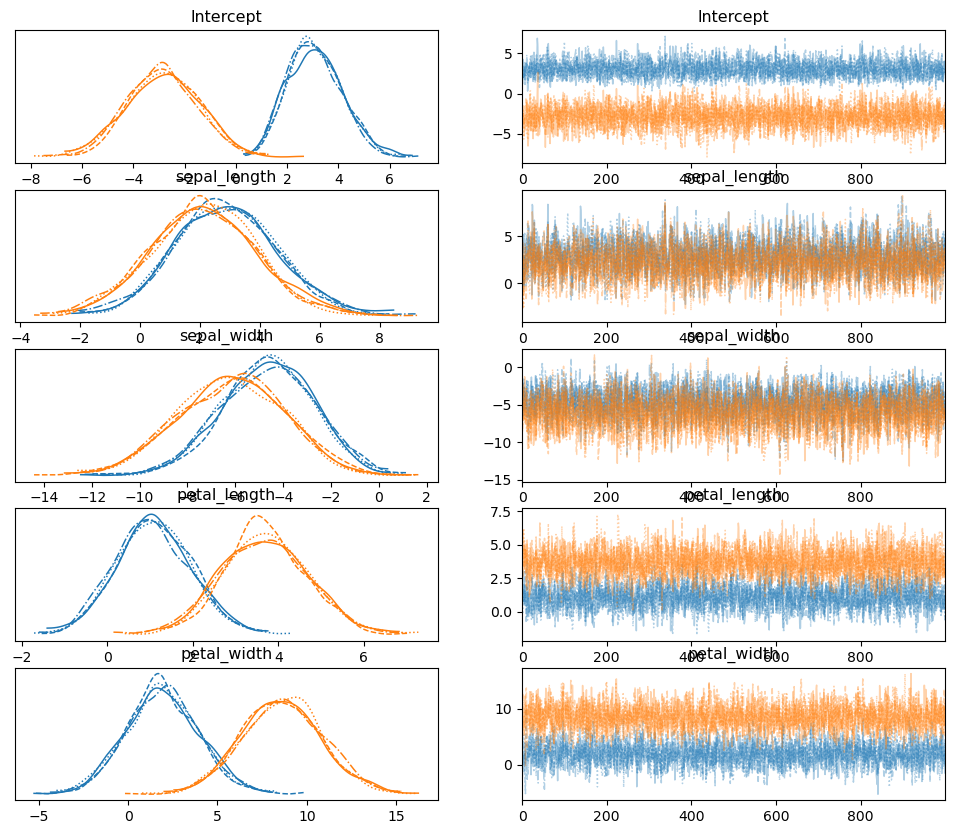

In [42]:
az.plot_trace(idata)

In [36]:
loo_full = az.loo(idata)
loo_pivot = az.loo(idata_pivot)

/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [38]:
az.compare({'full_model': idata, 'pivot_model': idata_pivot})



/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/ronaldlegere/miniconda3/envs/multinom/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
full_model,0,-10.981237,2.658916,0.000000,1.0,3.027626,0.000000,True,log
pivot_model,1,-11.836393,2.670665,0.855156,0.0,2.926610,0.266987,True,log


## Bambi version 
Reloading the data from sns

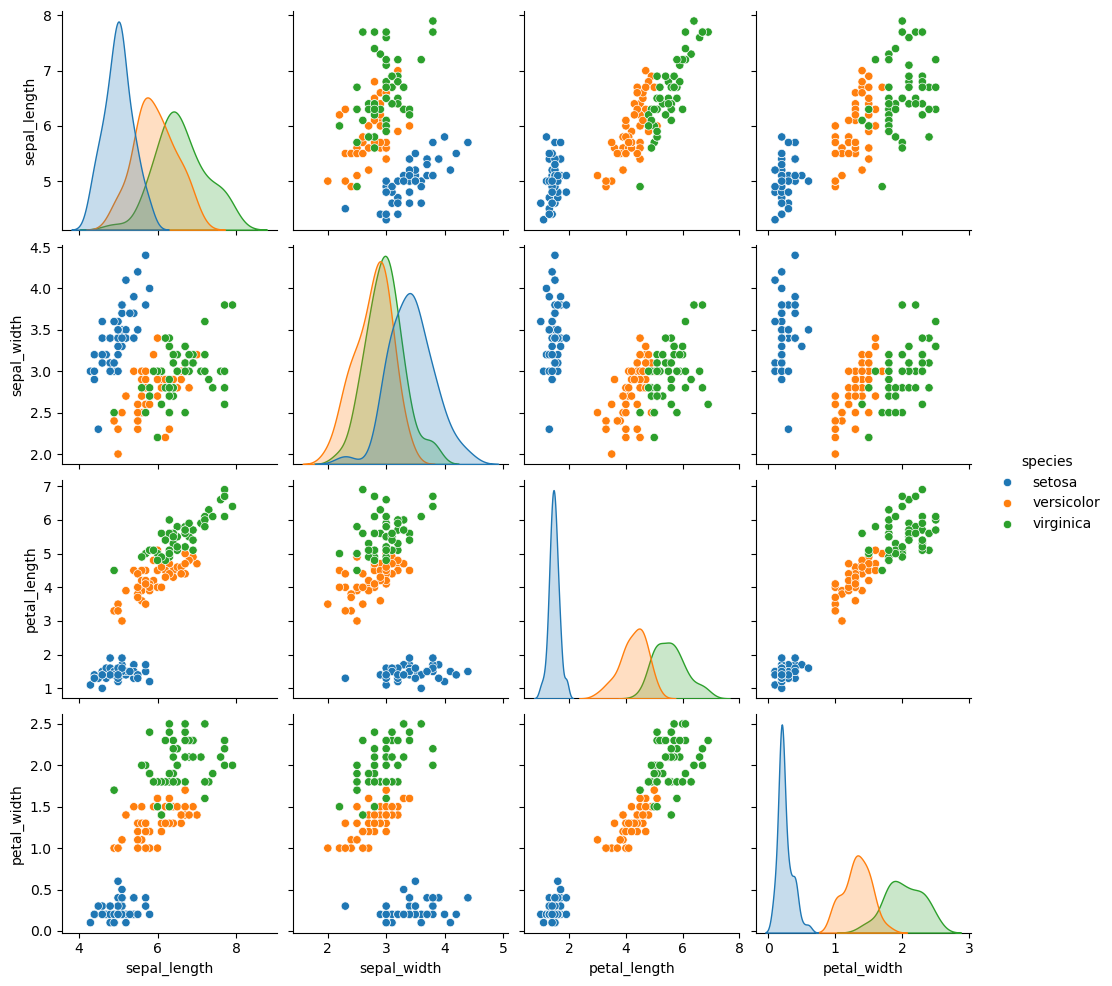

In [ ]:
import seaborn as sns 
iris = sns.load_dataset("iris")
sns.pairplot(iris, hue="species");

In [29]:
# Explicily center the length/width data (Bambi does this automatically , but i want to make comparison easier with pymc model)

iris['sepal_length'] = iris['sepal_length'] - iris['sepal_length'].mean()
iris['sepal_width'] = iris['sepal_width'] - iris['sepal_width'].mean()
iris['petal_length'] = iris['petal_length'] - iris['petal_length'].mean()
iris['petal_width'] = iris['petal_width'] - iris['petal_width'].mean()

In [30]:
# bambi version
import bambi as bmb
model = bmb.Model(
    "species ~ sepal_length + sepal_width + petal_length + petal_width", 
    iris, 
    family="categorical",
)


In [31]:
idata = model.fit()
az.summary(idata)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sepal_length, sepal_width, petal_length, petal_width]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[versicolor],3.080,1.037,1.277,5.044,0.020,0.015,2664.0,2640.0,1.0
Intercept[virginica],-2.842,1.388,-5.409,-0.264,0.025,0.022,3003.0,2961.0,1.0
sepal_length[versicolor],2.885,1.714,-0.245,6.190,0.037,0.028,2167.0,2429.0,1.0
sepal_length[virginica],2.132,1.768,-1.465,5.274,0.037,0.028,2355.0,2473.0,1.0
sepal_width[versicolor],-4.643,1.913,-7.998,-0.905,0.038,0.031,2590.0,2625.0,1.0
sepal_width[virginica],-6.184,2.215,-10.107,-1.960,0.044,0.035,2538.0,2425.0,1.0
petal_length[versicolor],1.088,0.881,-0.581,2.719,0.018,0.013,2441.0,2711.0,1.0
petal_length[virginica],3.694,1.004,1.754,5.488,0.019,0.016,2761.0,2658.0,1.0
petal_width[versicolor],1.917,2.025,-1.837,5.692,0.041,0.032,2429.0,2742.0,1.0
petal_width[virginica],8.599,2.223,4.304,12.735,0.043,0.031,2728.0,2750.0,1.0
